In [1]:
!pip install torch
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install scipy

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import euclidean
from torch.utils.data import Dataset, DataLoader

# Import Custom Activation Layers
import sys
sys.path.insert(0, '..')
from activationLayers import *

# Import RMHD Equations
from RMHDEquations import *

In [4]:
# Set device
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# Custom Neural Network
class RMHDPINN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden, hidden_width, activation=TrainableTanh(), output_projection=FinalActivation()):
        super(RMHDPINN, self).__init__()
        
        self.input_dim = input_size
        self.output_dim = output_size
        self.hidden_dim = hidden_width
        self.num_layers = n_hidden
        
        # Define U and V layers separately
        self.U_layer = nn.Linear(input_size, hidden_width)
        self.V_layer = nn.Linear(input_size, hidden_width)
        
        # Define hidden and output layers
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_width, hidden_width) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(hidden_width, output_size)
        
        # Set activation function
        self.phi = activation
        self.output_projection = output_projection
        
    def forward(self, t, x):
        t = t.unsqueeze(1) if len(t.shape) == 1 else t
        x = x.unsqueeze(1) if len(x.shape) == 1 else x
        X = torch.cat([x, t], dim=1)
        U_t = self.phi(self.U_layer(X))
        V_t = self.phi(self.V_layer(X))
        H = U_t  # initial value for H

        for layer in self.hidden_layers:
            Z = self.phi(layer(H))
            H = (1 - Z) * U_t + Z * V_t

        output = self.output_layer(H)
        # Print the shape of the tensor before it's passed to the FinalActivation

        return output


# Initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [6]:
# Hyperparameters
depth = 4
width = 16
activation = FinalActivation()
model = RMHDPINN(input_size=2, output_size=5, n_hidden=depth, hidden_width=width, activation=TrainableTanh(), output_projection=activation).to(device)
print(model)
model(torch.rand(10,device=device), torch.rand(10,device=device))

RMHDPINN(
  (U_layer): Linear(in_features=2, out_features=16, bias=True)
  (V_layer): Linear(in_features=2, out_features=16, bias=True)
  (hidden_layers): ModuleList(
    (0-3): 4 x Linear(in_features=16, out_features=16, bias=True)
  )
  (output_layer): Linear(in_features=16, out_features=5, bias=True)
  (phi): TrainableTanh()
  (output_projection): FinalActivation()
)


tensor([[ 0.0094,  0.3285,  0.2764, -0.3632, -0.5027],
        [-0.0950,  0.3163,  0.5336, -0.4778, -0.5135],
        [-0.2349,  0.2797,  0.5828, -0.4185, -0.5359],
        [ 0.2189,  0.4139,  0.3441, -0.5414, -0.4925],
        [ 0.2398,  0.4237,  0.4426, -0.6220, -0.4788],
        [-0.0130,  0.3207,  0.2821, -0.3514, -0.5030],
        [ 0.1283,  0.3919,  0.5035, -0.5928, -0.4799],
        [-0.0409,  0.2967,  0.1946, -0.2703, -0.4976],
        [ 0.0174,  0.3368,  0.3153, -0.3948, -0.5026],
        [ 0.0899,  0.3736,  0.4020, -0.4989, -0.4942]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [26]:
def initial_condition(x):
    condition1 = torch.tensor([1.0,0.0,0.0,0.0,49.3], device=device)
    condition2 = torch.tensor([1.0,0.0,0.0,0.7,2.5], device=device)
    newx = torch.flatten(x).to(device)
    return torch.outer(newx<0, condition1) + torch.outer(newx>=0, condition2)

In [28]:
def gradients(outputs, inputs, order = 1, device=device):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1) # Recursively take gradients
    else:
        return outputs

def rmhd_residual(pred,t,x):
    u_t= gradients(conserved_alfredo(pred),t)
    u_x= gradients(currents_alfredo(pred),x)
    return u_t + u_x


def random_domain(num_samples, t_range, x_range):
    t_random = torch.zeros(size=(num_samples, 1), device=device).uniform_(*t_range)
    x_random = torch.zeros(size=(num_samples, 1), device=device).uniform_(*x_range)
    t_random.requires_grad = True
    x_random.requires_grad = True
    return t_random, x_random



def random_boundary(num_samples, t_range, x_range, initial_to_boundary_ratio = 0.5):
    num_initial = int(initial_to_boundary_ratio * num_samples)
    num_boundary = num_samples - num_initial
    t_min, t_max = t_range

    # Generate initial condition samples
    t_initial = torch.zeros(size=(num_initial, 1), device=device)
    x_initial = torch.zeros(size=(num_initial, 1), device=device).uniform_(*x_range)
    u_initial = initial_condition(x_initial)

    # Generate boundary condition samples
    t_boundary = torch.zeros(size=(num_boundary, 1), device=device).uniform_(*t_range)

    # We assume x_range = (-1, 1) here
    x_boundary = 2 * torch.randint(0, 2, size=(num_boundary, 1), device=device) - 1
    u_boundary = initial_condition(x_boundary)#np.zeros((num_boundary, 1))

    return torch.tensor(t_initial, dtype=torch.float32), torch.tensor(x_initial, dtype=torch.float32), torch.tensor(u_initial, dtype=torch.float32), \
           torch.tensor(t_boundary, dtype=torch.float32), torch.tensor(x_boundary, dtype=torch.float32), torch.tensor(u_boundary, dtype=torch.float32)


In [31]:
lr = 0.005
model = RMHDPINN(input_size=2, output_size=5, n_hidden=depth, hidden_width=width, activation=TrainableTanh(), output_projection=activation).to(device)
#model = PINN(input_size=2, output_size=5, n_hidden=depth, hidden_width=width, activation=activation)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-4)
boundary_criterion = nn.MSELoss()
initial_criterion = nn.MSELoss()
domain_criterion = nn.MSELoss()
intermediate_criterion = nn.MSELoss()

In [32]:
num_epochs = 3000
model.train()

x_range, t_range = [-0.5, 0.5], [0, 1]
loss_history = []
domain_loss_history = []
initial_loss_history = []
boundary_loss_history = []
a_history = []
b_history = []
c_history = []
gradient_history = []

# Initialize lambda values
lambda_initial = 1.0
lambda_boundary = 1.0

max_schedule_steps = 1000
n = 100
for epoch in range(1, num_epochs + 1, max_schedule_steps):
    n += 7
    domain_samples = n**2
    for g in optimizer.param_groups:
        g['lr'] *= 3/4
    for step in range(0, max_schedule_steps):
        boundary_samples = 300  # You can change this value

        optimizer.zero_grad()
        
        domain_t, domain_x = random_domain(domain_samples, t_range, x_range)
        initial_t, initial_x, initial_u, boundary_t, boundary_x, boundary_u = random_boundary(boundary_samples, t_range, x_range, 0.5)
        domain_prediction = model(domain_t, domain_x)
        domain_residual = rmhd_residual(domain_prediction, domain_t, domain_x)
        initial_prediction = model(initial_t, initial_x)
        boundary_prediction = model(boundary_t, boundary_x)

        domain_loss = domain_criterion(domain_residual, torch.zeros_like(domain_residual))
        initial_loss = initial_criterion(initial_prediction, initial_u)
        boundary_loss = boundary_criterion(boundary_prediction, boundary_u)

        # # Step 3: Compute total loss and backpropagate
        loss = 10*domain_loss + lambda_initial * initial_loss + lambda_boundary * boundary_loss

        # Compute backward and update model parameters as usual
        loss.backward()
        optimizer.step()
        
        current_grads = [p.grad.clone() for p in model.parameters()]
        gradient_history.append(current_grads)
        
        loss_history.append(loss.item())
        domain_loss_history.append(domain_loss.item())
        initial_loss_history.append(initial_loss.item())
        boundary_loss_history.append(boundary_loss.item())

        
        if (epoch+step) % 100 == 0:
            print(f"Epoch: {epoch+step}, Loss: {loss}")

C:\Users\mxian\AppData\Local\Temp\ipykernel_13096\2172649982.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t_initial, dtype=torch.float32), torch.tensor(x_initial, dtype=torch.float32), torch.tensor(u_initial, dtype=torch.float32), \
C:\Users\mxian\AppData\Local\Temp\ipykernel_13096\2172649982.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(t_boundary, dtype=torch.float32), torch.tensor(x_boundary, dtype=torch.float32), torch.tensor(u_boundary, dtype=torch.float32)


Epoch: 100, Loss: 301.208251953125
Epoch: 200, Loss: 133.3043975830078
Epoch: 300, Loss: 87.05917358398438
Epoch: 400, Loss: 47.29533004760742
Epoch: 500, Loss: 39.25440216064453
Epoch: 600, Loss: 40.328941345214844
Epoch: 700, Loss: 30.016592025756836
Epoch: 800, Loss: 18.32484245300293
Epoch: 900, Loss: 22.680551528930664
Epoch: 1000, Loss: 25.154102325439453
Epoch: 1100, Loss: 56.331851959228516
Epoch: 1200, Loss: 15.171793937683105
Epoch: 1300, Loss: 16.590036392211914
Epoch: 1400, Loss: 14.008770942687988
Epoch: 1500, Loss: 14.458893775939941
Epoch: 1600, Loss: 14.97193431854248
Epoch: 1700, Loss: 11.619102478027344
Epoch: 1800, Loss: 10.684221267700195
Epoch: 1900, Loss: 12.67751407623291
Epoch: 2000, Loss: 9.33198356628418
Epoch: 2100, Loss: 8.053609848022461
Epoch: 2200, Loss: 9.094927787780762
Epoch: 2300, Loss: 17.590490341186523
Epoch: 2400, Loss: 7.827864646911621
Epoch: 2500, Loss: 8.559042930603027
Epoch: 2600, Loss: 7.573636054992676
Epoch: 2700, Loss: 5.362398624420166


In [21]:
model(domain_t, domain_x)

tensor([[ 0.1389,  0.0611, -0.8940, -0.0969,  0.1946],
        [ 0.9333,  0.1112,  0.1492,  0.0560,  0.8852],
        [ 0.8161,  0.2323, -0.2089,  0.0611,  0.8015],
        ...,
        [ 1.0355,  0.0546,  0.5405,  0.0388,  1.0006],
        [ 0.9194,  0.0897,  0.1572,  0.0418,  0.8739],
        [ 0.9971,  0.1819,  0.2658,  0.1100,  0.9575]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

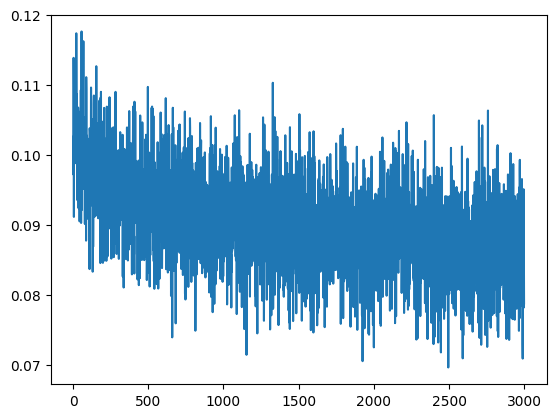

In [24]:
plt.plot(loss_history)

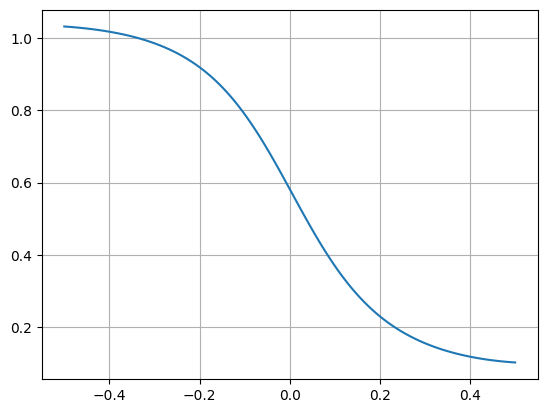

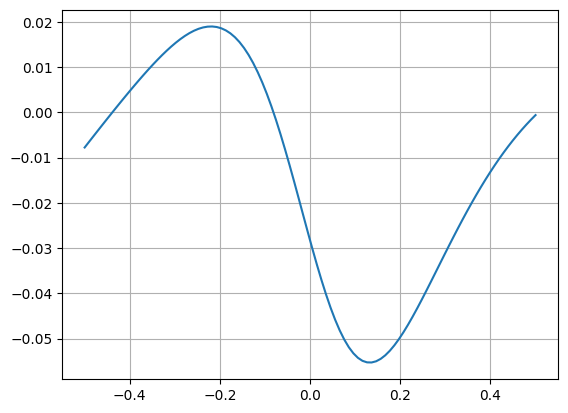

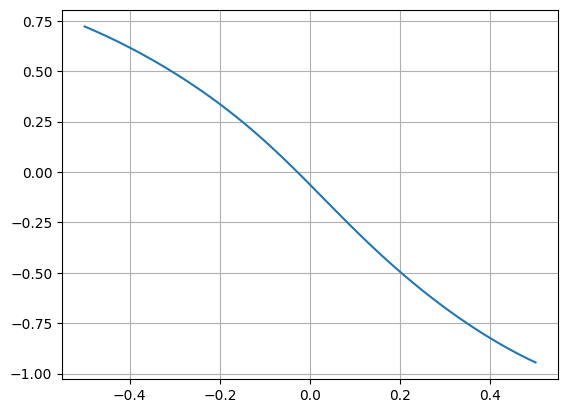

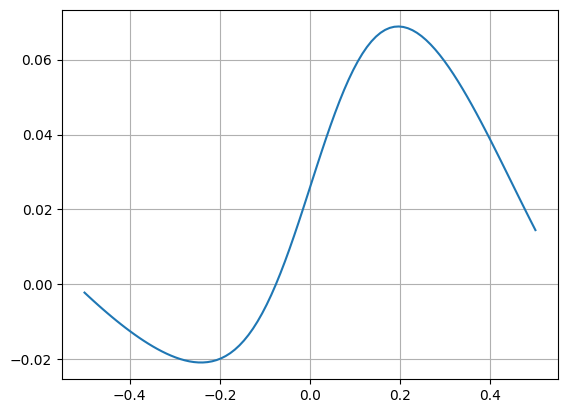

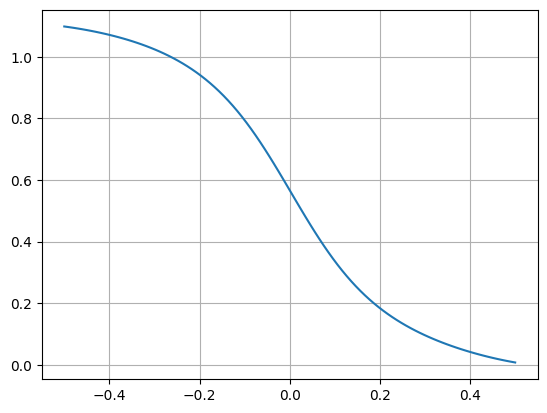

IndexError: index 5 is out of bounds for dimension 1 with size 5

In [25]:
model.eval()

tplot = 0  # 0.147

x = np.linspace(-0.5, 0.5, 100)
t = np.linspace(tplot, tplot, 1)

t, x = np.meshgrid(t, x)
t, x = t.flatten(), x.flatten()
t, x = torch.Tensor(t).to(device), torch.Tensor(x).to(device)
# numeric = inter_condition(tplot, x)
# numeric = numeric.reshape(100, 7)
prediction = model(t, x).detach()
prediction = prediction.reshape(100, 5)

# plt.imshow(prediction)

for i in range(7):

    # plt.plot(x.cpu().numpy(), numeric[:, i].cpu().flatten().numpy())
    plt.plot(x.cpu().numpy(), prediction[:, i].cpu().flatten().numpy())
    plt.grid(True)
    plt.show()